# Slack Webscraper ArticlesClassifier

This code implements a multi-agent system for classifying and analyzing web articles.
The system uses a multi-agent architecture where each agent specializes in a specific task
(e.g., data extraction, classification, analysis). The agents work together through a routing
system that directs tasks to the corresponding expert agent.

The implementation is based on LangGraph and is inspired by the AutoGen paper describing
multi-agent architectures for LLM applications. The system is designed to efficiently process
and classify web articles obtained from Slack channels in a scalable way.

## Setup

First, let's install our required packages and set our API keys:

In [173]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core
%pip install -qU langchain-community slack_sdk
%pip install -qU beautifulsoup4 

In [174]:
import os
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
SLACK_APP_TOKEN = os.getenv("SLACK_APP_TOKEN")
SLACK_BOT_TOKEN = os.getenv("SLACK_BOT_TOKEN")

# Slack Channel Link Extraction

This section implements functionality to extract links shared in a Slack channel:

- Uses the Slack Web API to fetch message history
- Extracts URLs from message text and attachments 
- Filters out internal novatide links
- Stores unique URLs in a text file
- Includes logging for tracking the extraction process

The code below sets up logging, initializes the Slack client,
and defines the core link extraction function.

In [175]:
import logging
import os
import re
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Configure logging to show INFO level messages in console
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Create Slack client instance using bot token
client = WebClient(token=SLACK_BOT_TOKEN)

def fetch_unique_links(channel_id, limit=10):
    """
    Extracts all unique URLs (excluding those containing "novatide") shared in a Slack channel.
    
    Parameters:
        channel_id (str): ID of the Slack channel to extract URLs from.
        limit (int, optional): Maximum number of messages to review (max allowed: 1000).
                             Default is 100.
    
    Returns:
        set: Set of all unique URLs found in the channel.
    """
    try:
        # Call conversations_history method to get messages
        response = client.conversations_history(channel=channel_id, limit=limit)
        messages = response["messages"]
        urls = set()  # Use a set to automatically avoid duplicates

        # Iterate through messages to find URLs
        for msg in messages:
            # Search for URLs in message text
            if 'text' in msg:
                for url in re.findall(r'(https?://[^\s]+)', msg['text']):
                    if "novatide" not in url:
                        urls.add(url)
            
            # Search for URLs in message attachments
            if 'attachments' in msg:
                for attachment in msg['attachments']:
                    if 'from_url' in attachment:
                        url = attachment['from_url']
                        if "novatide" not in url:
                            urls.add(url)

        logger.info(f"Extracted {len(urls)} unique URLs from channel {channel_id}.")
        return urls

    except SlackApiError as e:
        # Handle Slack API errors
        logger.error(f"Error getting messages: {e.response['error']}")
        return set()

# Example usage: extract all unique URLs from a channel
channel_id = "C05URLDF3JP"  # Replace with channel ID
unique_urls = fetch_unique_links(channel_id)

# Save unique URLs to a file
output_file = "slack_urls/slack_channel_links_extracted.txt"
try:
    with open(output_file, 'w', encoding='utf-8') as file:
        for url in unique_urls:
            file.write(url + '\n')
    logger.info(f"Unique URLs successfully saved to {output_file}")
except Exception as e:
    logger.error(f"Error saving URLs: {e}")

INFO:__main__:Extracted 8 unique URLs from channel C05URLDF3JP.
INFO:__main__:Unique URLs successfully saved to slack_urls/slack_channel_links_extracted.txt


### 1. Imports required libraries.

### 2. Sets up a Tavily search tool that:
 - Returns max 5 search results
 - Includes images in results

### 3. Defines a scrape_webpages function that:
- Takes a list of URLs as input
- Uses WebBaseLoader to scrape content from each URL
- Loads and parses the web pages into documents
- Formats each document with its title and content
- Returns all documents joined together as a single string
- Each document is wrapped in XML-like tags with metadata

In [176]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

# Initialize Tavily search tool with 5 max results and image inclusion
tavily_tool = TavilySearchResults(max_results=5,include_images=True )

@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information.
    
    Args:
        urls: List of URLs to scrape
        
    Returns:
        String containing the concatenated content of all scraped pages
    """
    # Initialize web loader for the provided URLs
    loader = WebBaseLoader(urls)
    # Load and parse the documents
    docs = loader.load()
    # Join all documents with metadata into a single formatted string
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

## This code defines several tools and utilities for document management and financial data retrieval:
### 1. Document Management Tools:
- create_outline(): Creates and saves document outlines with numbered points
- read_document(): Reads contents of a document with optional line range
- write_document(): Writes content to a document file
- edit_document(): Edits documents by inserting text at specific line numbers
- python_repl(): Executes Python code and returns results. Ideal to create the code to execute charts
### 2. Financial Data Tools using yfinance:
- company_information(): Gets company details like address, financials, etc.
- last_dividend_and_earnings_date(): Retrieves dividend and earnings dates
- summary_of_mutual_fund_holders(): Gets top mutual fund holders info
- summary_of_institutional_holders(): Gets top institutional holders info 
- stock_grade_upgrades_downgrades(): Retrieves stock rating changes
- stock_splits_history(): Gets historical stock split data
- stock_news(): Retrieves latest news articles about a stock

In [177]:
# Import required libraries and set up temporary directory for file operations
import yahoofinance as yf
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


# Tool to create and save document outlines
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"

# Define document paths and load their content
CLASSIFICATION_DOCS = {
    "discrepancies": "C:\\Users\\rios1\\LangGraphAgentsTest\\articles_classifier_agents\\improvements_docs\\Classification Discrepancies in Content Scoring.txt",
    "system": "C:\\Users\\rios1\\LangGraphAgentsTest\\articles_classifier_agents\\improvements_docs\\Classification System for Cryptocurrency Documents.txt",
    "verification": "C:\\Users\\rios1\\LangGraphAgentsTest\\articles_classifier_agents\\improvements_docs\\Verifying the accuracy of the agent classification.txt"
}

# Load documents content at initialization
DOCS_CONTENT = {}
for doc_key, file_path in CLASSIFICATION_DOCS.items():
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            DOCS_CONTENT[doc_key] = file.read()
    except Exception as e:
        logger.error(f"Error loading {doc_key} document: {e}")
        DOCS_CONTENT[doc_key] = f"Error loading document: {e}"
@tool
def read_document(
    doc_type: Annotated[str, "Type of document to read (discrepancies/system/verification)"],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified classification document."""
    if doc_type not in DOCS_CONTENT:
        return f"Invalid document type. Available types: {', '.join(DOCS_CONTENT.keys())}"
    
    content = DOCS_CONTENT[doc_type]
    if start is not None or end is not None:
        lines = content.split('\n')
        return '\n'.join(lines[start:end])
    return content


# Tool to write content to a document
@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


# Tool to edit documents by inserting text at specific line numbers
@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Python REPL tool for executing code
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

# Import required tools and date handling
from langchain_core.tools import tool
from datetime import date

# Tool to get company information
@tool
def company_information(ticker: str) -> dict:
    """Use this tool to retrieve company information like address, industry, sector, company officers, business summary, website,
       marketCap, current price, ebitda, total debt, total revenue, debt-to-equity, etc."""

    ticker_obj = yf.Ticker(ticker)
    ticker_info = ticker_obj.get_info()

    return ticker_info

# Tool to get dividend and earnings dates
@tool
def last_dividend_and_earnings_date(ticker: str) -> dict:
    """
    Use this tool to retrieve company's last dividend date and earnings release dates.
    It does not provide information about historical dividend yields.
    """
    ticker_obj = yf.Ticker(ticker)

    return ticker_obj.get_calendar()

# Tool to get mutual fund holders information
@tool
def summary_of_mutual_fund_holders(ticker: str) -> dict:
    """
    Use this tool to retrieve company's top mutual fund holders.
    It also returns their percentage of share, stock count and value of holdings.
    """
    ticker_obj = yf.Ticker(ticker)
    mf_holders = ticker_obj.get_mutualfund_holders()

    return mf_holders.to_dict(orient="records")

# Tool to get institutional holders information
@tool
def summary_of_institutional_holders(ticker: str) -> dict:
    """
    Use this tool to retrieve company's top institutional holders.
    It also returns their percentage of share, stock count and value of holdings.
    """
    ticker_obj = yf.Ticker(ticker)
    inst_holders = ticker_obj.get_institutional_holders()

    return inst_holders.to_dict(orient="records")

# Tool to get stock grade changes
@tool
def stock_grade_upgrades_downgrades(ticker: str) -> dict:
    """
    Use this to retrieve grade ratings upgrades and downgrades details of particular stock.
    It'll provide name of firms along with 'To Grade' and 'From Grade' details. Grade date is also provided.
    """
    ticker_obj = yf.Ticker(ticker)

    curr_year = date.today().year

    upgrades_downgrades = ticker_obj.get_upgrades_downgrades()
    upgrades_downgrades = upgrades_downgrades.loc[upgrades_downgrades.index > f"{curr_year}-01-01"]
    upgrades_downgrades = upgrades_downgrades[upgrades_downgrades["Action"].isin(["up", "down"])]

    return upgrades_downgrades.to_dict(orient="records")

# Tool to get stock split history
@tool
def stock_splits_history(ticker: str) -> dict:
    """
    Use this tool to retrieve company's historical stock splits data.
    """
    ticker_obj = yf.Ticker(ticker)
    hist_splits = ticker_obj.get_splits()

    return hist_splits.to_dict()

# Tool to get stock news
@tool
def stock_news(ticker: str) -> dict:
    """
    Use this to retrieve latest news articles discussing particular stock ticker.
    """
    ticker_obj = yf.Ticker(ticker)

    return ticker_obj.get_news()

## This code sets up a multi-agent system using LangGraph. Here's a breakdown of its key components:
### 1. Imports and Model Initialization:
- Sets up the latest GPT-4 model as the base language model
- Includes commented alternatives for other LLMs (Claude, Mixtral, Gemini, etc.)
### 2. Message Trimming Setup:
- Handles long conversations by trimming messages to fit within token limits
- Keeps the most recent messages when context gets too long
### 3. Agent Node Function:
- Creates a standardized way for agents to process and return messages
- Maintains conversation state between different agents
### 4. Team Supervisor Creation:
- Creates a routing agent that decides which team member should act next
- Uses a function-calling approach to make routing decisions
-Can choose between team members or decide to finish the conversation
### 5. Tools Definition:
- Defines financial analysis tools available to the agents
- These tools can fetch various types of financial data and company information


In [178]:
# Import required libraries
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage, trim_messages

# Initialize OpenAI chat model
llm = ChatOpenAI(model="gpt-4-0125-preview")

# OpenAI Models
#llm = ChatOpenAI(model="gpt-4")  # Most capable OpenAI model
#llm = ChatOpenAI(model="gpt-3.5-turbo")  # Good balance of capability/cost
#llm = ChatOpenAI(model="gpt-3.5-turbo-16k")  # Larger context window
#
## Anthropic Models
#from langchain_anthropic import ChatAnthropic
#llm = ChatAnthropic(model="claude-3-opus-20240229")  # Most capable Claude model
#llm = ChatAnthropic(model="claude-3-sonnet-20240229")  # Good balance model
#llm = ChatAnthropic(model="claude-2.1")  # Previous generation Claude
#
## Open Source Models via Together AI
#from langchain_community.chat_models import ChatTogetherAI  
#llm = ChatTogetherAI(model="mistralai/Mixtral-8x7B-Instruct-v0.1")
#llm = ChatTogetherAI(model="meta-llama/Llama-2-70b-chat-hf")
#
## Google Models
#from langchain_google_genai import ChatGoogleGenerativeAI
#llm = ChatGoogleGenerativeAI(model="gemini-pro")

trimmer = trim_messages(
    max_tokens=100000,
    strategy="last",
    token_counter=llm,
    include_system=True,
)

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | trimmer
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

tools = [
         company_information,
         last_dividend_and_earnings_date,
         stock_splits_history,
         summary_of_mutual_fund_holders,
         summary_of_institutional_holders,
         stock_grade_upgrades_downgrades,
         stock_news
]

In [179]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

# Define the members and system prompt
members = ["WebScraper", "supervisor", "Classifier","Search"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Define the options for the next step
options = ["FINISH"] + members

# Update the RouteResponse class to match the casing
class RouteResponse(BaseModel):
    next: Literal['FINISH', 'WebScraper', 'Classifier', 'Search']  # Match the casing with members list
# Create a prompt template
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

# Initialize the ChatOpenAI model
llm = ChatOpenAI(model="gpt-4-0125-preview")

# Define the supervisor agent function
def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(RouteResponse)
    )
    return supervisor_chain.invoke(state)

# Example usage of supervisor_agent function
# Example state can be defined here based on your use case
# state = {"messages": ... }
# response = supervisor_agent(state)
# print(response)


Here's a summary of what this code does:
The code implements a multi-agent system for classifying cryptocurrency-related articles using a team of specialized AI agents:
1. Agent Structure:
- document_reader_agent: Learns classification criteria from example documents
- research_agent (WebScraper): Extracts content from web articles
- classifier_agent: Scores articles on a 1-10 scale using detailed criteria
- supervisor_agent: Coordinates the workflow between agents
2. Key Features:
Uses LangGraph for agent coordination and workflow management
Implements a detailed 1-10 scoring system for crypto content:
- Score 1-3: Low quality/misleading content
- Score 4-5: Basic/superficial information
- Score 6-7: Good quality analysis
- Score 8-9: High-quality technical analysis
- Score 10: Foundational/transformative work (e.g., Bitcoin whitepaper)
Each agent has specific tools and responsibilities
The supervisor ensures proper sequencing: DocumentReader → WebScraper → Classifier

In [180]:
import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from typing_extensions import TypedDict
from typing import Annotated, List

# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str

search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

research_agent = create_react_agent(llm, tools=[scrape_webpages], state_modifier="Enter to the provided url and then retrive that data to the Classifier")
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

document_reader_agent = create_react_agent(llm, tools=[read_document], state_modifier="""
You are a classification review agent that evaluates the scoring decisions made by the Classifier agent. Your role is to:

1. Review the score and justification provided by the Classifier
2. Compare against the classification examples and discrepancies document
3. Determine if the classification aligns with established criteria and past examples
4. Provide a detailed evaluation following this exact structure:

CLASSIFICATION REVIEW
-------------------
Article Source: [Specify source]
Classifier Score: [Score given, always find the score of the Classifier agent]
Reviewer Score: [Your score]

SCORE ANALYSIS
-------------
[Agree/Disagree] with Classifier's score for the following reasons:
- [List specific reasons with bullet points]
- [Reference specific criteria from scoring system]
- [Compare to similar examples from discrepancies document]

DETAILED JUSTIFICATION
---------------------
Why Not Lower Score:
- [Explain why article exceeds criteria for lower scores]

Why Not Higher Score:
- [Explain why article doesn't meet criteria for higher scores]

COMMON ERRORS ASSESSMENT
----------------------
- [Identify if any common classification errors were made/avoided]
- [Reference specific examples from discrepancies document]

FINAL RECOMMENDATION
-------------------
[Provide final score recommendation with clear reasoning]

Your evaluation must:
1. Be objective and based strictly on the scoring criteria
2. Reference specific examples and patterns from the discrepancies document
3. Highlight both strengths and weaknesses in the classification
4. Provide clear reasoning for any score adjustments
5. Note any edge cases or nuances that affected the scoring

Analyze the response based on the discrepancies mention here:


Based on the article from the news-bot-layer-2 channel on Slack, I have identified a discrepancy between my classification and ChatGPT's when assigning a score to the content. ChatGPT rated it as a score of 4, while I have assigned it a score of 5 for the following reasons:


* A score 4 is usually factually correct but lacks detailed exploration, only scratches the surface of the topic but context or depth is minimal. However, the analyzed article, while still somewhat superficial, it does provide additional context and connects better with the main topic.
* The analyzed content, unlike content belonging to the score 4, a score 5 content flows better, making it easier to follow without being extensive.
* For a score 4, typically no innovative ideas or critical thinking is presented. However, in this article analyzed, it has introduced some perspectives and simple reflection that enhanced understanding, even if not particularly innovative.
* Clarity but lack of engagement.
* On score 4, there are relevant metrics that are shared, however, there is no deeper explanation of what implications they might have on the ecosystem. Based on the article analyzed, there are some explanations in relation to what implications they might have on the ecosystem, for example, there is explanation on the large movements on the substantial transactions that polygon experienced with large holders of the token MATIC, moving significant sums of the token.
* Typically on a score 4, the content is limited to only summarizing or listing information, with no further insight into how or why it matters. However, on the article analyzed, the information is clearly not only listing information, but it also goes into a little more detail than a simple listing regarding the Whale Movements Signal and the potential changes, technical Indicators, the on-chain data, etc. Giving some context why it matters and some slight explanation of what they mean and some subtle implications. Albeit in a still superficial way but it does so, something that score 4 has yet to achieve.
* The article basically maintained the factual accuracy and clarity of the score 4 but with the already improvements mentioned. Adding a small degree of depth and relevance to the basic structure of score 4, without reaching a comprehensive analysis level that a score 6 will be achieving.


ChatGPT’s Classification Summary
* Score Assigned: 4 (Moderate Quality / Basic or Superficial Information)
* Justification: Factually accurate but lacks deep exploration and relies on summary without critical insights.
Classification Explanation
The article falls into Score 4 due to its factual accuracy and moderate overview of whale activities and technical indicators surrounding MATIC. The information is reliable but lacks depth, innovative insights, or technical analysis that would elevate it to higher quality. The piece merely summarizes basic indicators and on-chain data without breaking down complex technicalities or providing a critical analysis of their implications.
Justification Against Lower Scores
* The content does not contain misleading or speculative information. It avoids exaggerated or alarmist tones, providing factual summaries rather than sensational or speculative statements, which excludes it from Score 1-3.
Justification Against Higher Scores
* For a higher score, such as 6 or 7, the article would need to include deeper technical analysis, explore the long-term impact of whale activity and indicators, and provide structured analysis with more critical perspectives. The superficial summary style and lack of innovative insights keep it within the basic information range (Score 4).


Example 2: Score 4 vs. Score 5 Analysis for news-bot articles.


Based on another article from the news-bot-layer-2 channel on Slack, this is the other discrepancy I have identified between my classification and ChatGPT's. ChatGPT rated this article, as a score of 5, while from my perspective, according to the rules, it falls into score 4 for the following reasons:


A score 5 would maintain the factual accuracy and clarity of score 4 but with the following improvements: 


* While still somewhat superficial, it provides additional context and connects better with the main topic. However, the article analyzed, is factually correct but lacks detailed exploration, only scratches the surface of the topic but context or depth is minimal.
* Score 5 introduces some additional perspectives or simple reflections that enhance understanding, even if not particularly innovative. In this regard, the article does not introduce innovative ideas or critical thinking.
* Score 5 contents are more structured and flow better, making it easier to follow without being extensive. The analyzed content is a short one, not extensive, however, it lacks a fully clear structure as the article begins with a headline and introduction, but it could be clearer about the main points right away. A structured introduction summarizing key points such as Coinbase’s addition of POL, the transition from MATIC, and Polygon’s roadmap could improve clarity. There is also a lack of define sections which makes it harder to navigate. And lastly, the sequence of information is somewhat disjointed. For example, the article introduces the rebranding, then shifts to details on community decisions, and then moves back to Coinbase’s listing information. A more chronological or thematic approach would provide a clearer flow.
* On score 5, technical details are slightly expanded, and there’s some basic explanation of how certain technologies or protocols function. In this analyzed article, there are not technical aspects that are expanded. The article focuses primarily on the logistics and procedural details of the POL token's upcoming launch, rebrand, and listing on Coinbase. It briefly mentions POL’s role in future Polygon functionality (like staking, gas fees, and participation in Data Availability Committees), but it does not explain how these technologies or processes work. Instead, the article assumes a reader's familiarity with these concepts and provides only surface-level information on the token's transition without going deeper into the technical mechanics or the functioning of Polygon's technology stack.
* On score 5 contents, instead of just listing or summarizing information, it briefly explains why certain aspects matter, giving it more practical significance. In this analyzed article, the content is limited to summarizing the information, with no further insight into how or why it matters.


This article has more features of a score 4, it definitely has clarity but lack of engagement for the already mentioned reasons above.
ChatGPT’s Classification Summary
* Score Assigned: 5 (Moderate Quality / Basic or Superficial Information)
* Justification: 
   * Provides clear, factual information on POL’s listing and transition details.
   * Lacks in-depth analysis or technical exploration, making it more of a straightforward update than an analytical piece.
Classification Explanation
* Accurate and Informative: The article provides factual information about the upcoming POL token and its listing on Coinbase’s roadmap, as well as the broader context of Polygon’s rebranding from MATIC to POL. It explains the purpose of the rebrand, upcoming changes, and future plans for POL's utility, offering readers basic yet accurate insights.
* Lacks Depth and Technical Analysis: While the article includes relevant information about the rebranding process and its initial utility, it lacks deeper technical exploration of how the transition to POL will impact Polygon's technical landscape or broader ecosystem. It is mostly a straightforward summary without critical analysis or in-depth insights.
Justification for Score
* Why Not Score 4: The article goes beyond a surface-level summary by providing contextual details on the transition and quoting statements from developers, making it more comprehensive than basic content rated as Score 4.
* Why Not Score 6: Although informative, the article does not delve into technical specifics or provide a substantial analysis of POL’s strategic impact on Polygon's ecosystem. It lacks the depth of analysis required for a higher score.


Summary of Adjacent Differences in ChatGPT vs. Human Ratings
Example 1: Score 4 (ChatGPT) vs. Score 5 (Belen)
* Interpretation of Depth: ChatGPT often interprets articles as Score 4 if they primarily summarize information without introducing substantial context or depth. In this case, ChatGPT viewed the article as basic and factual without critical insights, typical of Score 4. However, I have considered the article a Score 5 because it introduced slight reflections on whale movements and technical indicators, giving it a bit more depth than a straightforward summary (a very typical approach on score 4 contents).
* Engagement and Structure: ChatGPT tends to classify articles as Score 4 if they are clear but lack engaging or well-structured content. I have rated this as Score 5 due to its better flow and engagement, as well as its slight expansion on relevant points, which added context even if not highly analytical.
* Interpretation of “Insight”: ChatGPT sees Score 4 content as strictly listing or summarizing data, while Score 5 content would begin to hint at “why it matters.” I have seen the article’s brief explanation of whale movements’ implications as adding relevance, a small but significant difference that justified a Score 5.
Example 2: Score 5 (ChatGPT) vs. Score 4 (Belen)
* Expectation of Basic Explanation: ChatGPT rated this article as Score 5, indicating it provided enough context and additional perspectives to be slightly above basic. However, I have rated it as Score 4, as the article focused on logistical details without introducing even basic explanations of technical concepts (e.g., staking, DACs), which Score 5 would typically include.
* Structure and Organization: ChatGPT’s Score 5 rating reflects an interpretation that the article had sufficient structure and flow for moderate engagement. In this regard, I have disagreed, noting that the article’s disjointed organization and lack of a clear introduction or thematic flow limited it to Score 4. This difference in expectation around structure and coherence is a recurring adjacent difference.
* Practical Relevance vs. Procedural Listing: ChatGPT rated this article as Score 5 partly due to its coverage of POL’s role and roadmap, assuming this provided enough context to be practically relevant. I have rated it as Score 4, seeing it as merely procedural information without further insight into why the details matter.
Key Adjacent Differences Between ChatGPT and Human’s rating according to the available set of rules.
1. Depth and Context: ChatGPT may assign a lower score if it perceives content as merely summarizing, while the individual who is in charge of rating the content according to the set rules, may see added reflections or contextual clues as warranting a higher score.
2. Basic Explanation of Technical Terms: ChatGPT considers moderate-quality content (Score 5) to include a basic summary, while the individual in charge may rate content lower if explanations of technologies, metrics or why something matters are absent, keeping it within a more procedural summary.
3. Structure and Flow:
* ChatGPT: May consider content adequately structured for a mid-tier score if it presents information clearly, even if the organization is not ideal.
* Human: Places more emphasis on logical flow and structured presentation. Content with a disjointed or unclear organization is often rated lower, as clarity in sequence and flow is seen as essential for engagement and understanding.
4. Practical Significance vs. Procedural Listing:
* ChatGPT: May assign a higher score if the content includes relevant details, assuming this provides practical significance, even without extensive exploration of why the details matter.
* Human: More critical of content that lists or summarizes procedural information without discussing its implications. Higher scores are reserved for content that goes beyond listing facts to explain why they are important.
5. Engagement and Reader Value:
   * ChatGPT: Considers factual accuracy and moderate detail sufficient for middle-range scores, often viewing straightforward summaries as meeting the criteria for moderate engagement.
   * Human: Values engagement and depth, assigning higher scores to content that brings added insights or reflections that enhance reader value, rather than just summarizing.
Summary of Adjacent Differences
* ChatGPT's scoring leans towards a focus on factual clarity and relevance at a basic level, while our humanistic ratings emphasize the added value of context, technical explanations, and well-structured presentation.
* From the humanistic point of view and according to the established rules, the highest points in this case of comparison (score 4 and score 5) are reserved for content that moves beyond procedural detail to include implications, practical insights, or a coherent flow.

Take in account this discrepancies: 

""")
document_reader_node = functools.partial(agent_node, agent=document_reader_agent, name="DocumentReader")

classifier_agent = create_react_agent(llm, tools=[read_document],state_modifier= """
Main Objective: To classify cryptocurrency documents, articles, and content using a score from 1 to 10. The 1-10 scale provides a clear way to measure content quality, depth, and relevance. The goal is to rank documents based on quality, accuracy, depth, and relevance based on the scores that goes from score 1 to score 10. A score of 1 means the lowest quality (Extremely Low Quality / False or Misinformation or Clickbait) and a 10 score represents the highest-quality (Exceptional / Foundational and Transformative Quality, like important whitepapers such as Bitcoin or Ethereum).

This is the Classification System Structure

1. Scoring Definition (1 to 10)
Below are the definitions for each score, from 1 to 10. 

Score 1: Extremely Low Quality / False or Misinformation or Clickbait
Description: Score 1 represents the lowest possible quality of content, characterized by incorrect or false information that could actively mislead or misinform the reader. This type of content often contains outright inaccuracies, completely unverified claims, or fabricated data. It is typically sensationalist in nature and may be designed purely to attract clicks, with little regard for the accuracy or integrity of the information.

Criteria:

Contains completely false or fabricated information.
Harmful to readers and may lead them to make unsafe financial decisions.
Uses sensational headlines to generate clicks.
Contains no credible sources or references to back up its claims.
Contains incorrect data or unverifiable claims.

Rule:
Automatic Score 1 if any one of the following is met:

:x:Completely false or fabricated information.
:x:Appears harmful or misleading, causing unsafe actions.

Exception:
If the content uses exaggerated or clickbait headlines but contains partially true information, it may fall into Score 2 instead.

Score 2: Mostly Inaccurate or Misleading

Description: Score 2 content is only marginally better than Score 1, as it may contain some accurate information but is predominantly misleading, incomplete, or poorly researched. Content rated as a Score 2 is typically misleading, speculative, or incomplete. It often includes some elements of truth, but these are either exaggerated, taken out of context, or mixed with speculative or unverified claims that distort the overall message. While it might contain fragments of accurate information, these are overshadowed by a lack of evidence, poor reasoning, or unsubstantiated accusations. As a result, content in this range may mislead or confuse readers, leading to incorrect interpretations or actions.

Criteria:

Misleading or Speculative information that exaggerates facts.
Uses very hight speculative language presented as more factual than it is.
Can be partially true but lacking of evidences 
Lack of credible sources for key claims.
Contains major contextual gaps, leading to misinterpretation.
Overstates events with alarmist or exaggerated tones.
Potential for Harm: Unverified claims can cause panic, damage reputations, and lead to misinformed actions.
Clickbait-Like: Uses sensationalist or misleading interpretations to attract attention.
Incomplete or Unverified: Based on partial truths without proper context or verification.
Does not even provide a minimal context or explanation (absence of background or reasoning).

Rule:

Automatic Score 2 if any of the following are present:
:x:Unverified claims that can potentially cause harm or panic and damage reputations.
:x:No minimal context or explanation (absence of background and reasoning).
:x:Alarmist or exaggerated tones.
:x:Major contextual gaps leading to confusion.


Score 3: Very Low Quality / Highly Speculative and Inaccurate Information

Description: Content that falls under the 3 score category is considered very low quality. It is often speculative, lacks evidence, and provides little to no analytical value. The information might be based on assumptions or incomplete analysis, and often serves as clickbait rather than delivering meaningful insights. These materials generally do not contribute to a reader’s deeper understanding of the topic and may contain incorrect or misleading interpretations.

Criteria:

Remains speculative with little to no supporting data.
Provides a minimal context or explanation, but no analysis or depth, it relies on superficial or simplistic narratives.
No supporting evidence, unverified data or assumptions are presented as facts.
Lacks a structured format, making it hard to follow.
Engagement-Oriented 

Rule: 

A content automatically receives Score 3 if it provides a minimal context or explanation while not exhibiting the attributes of Score 2 criteria.
If the content is vaguely related to the crypto community, whether it’s about a crypto festival, a crypto meetup, or any cultural event that still ties to crypto, but the content doesn’t go beyond this superficial or simplistic narrative, it would also fall directly into score 3. Regardless of whether it has credible sources and whether it is well-structured and so on.
If it lacks the minimal context and explanation, it drops to Score 2.

Score 4-5: Moderate Quality / Basic or Superficial Information

Description: Content provides correct and reliable information but tends to remain superficial or basic. While the information may be factually accurate and sourced from reliable places, it lacks depth, critical analysis, and innovative insights. While score 4 provides correct and reliable information, it can include some speculative scenarios, but less than score 3. This kind of content offers a surface-level understanding of a topic but lacks deep exploration or original thought.

Criteria for a score 4:

Factually correct but lacks detailed exploration, only scratches the surface of the topic but context or depth is minimal.
No innovative ideas or critical thinking is presented.
Clarity but lack of engagement.
There is little exploration of technical details. There are also mentions of technology but without analyzing it. There are relevant links or metrics that are shared, however, there is no deeper explanation of how protocols work, why certain integrations are important, or what implications they might have on the ecosystem.
The content is limited to summarizing or listing information, with no further insight into how or why it matters. It can still provide some speculative tone and scenarios, but less than score 3.

60% Rule: The content must meet 3 criteria in order to qualify in the Score 4, and must meet the following criteria for a score 5:

A score 5 would maintain the factual accuracy and clarity of score 4 but with the following improvements: 

More context: While still somewhat superficial, it provides additional context and connects better with the main topic.
Basic development of Ideas: Introduces some additional perspectives or simple reflections that enhance understanding, even if not particularly innovative.
Improved organization: Content is more structured and flows better, making it easier to follow without being extensive.
Slight expansion of technical details: Technical details are slightly expanded, and there’s some basic explanation of how certain technologies or protocols function.
Added relevance: Instead of just listing information, it briefly explains why certain aspects matter, giving it more practical significance.

A score 5 adds a small degree of depth and relevance to the basic structure of score 4, without reaching a comprehensive analysis level.

Score 6-7: Good Quality / Proper Analysis but no Innovation

Description: Content within the 6-7 score range is considered solid and reliable, providing accurate and relevant information, but lacks the depth and innovation that would make it highly impactful. It offers a clear understanding of key concepts and data, usually supported by reputable sources, but stops short of offering new insights or advanced analysis. This type of content is useful and informative, but it mainly serves to present known information without breaking new ground.

Criteria for a score 6:

Accurate and well-sourced: Includes solid sources and factual accuracy throughout, with references that support the core arguments.
Technical detail is explored but not fully developed (basic to moderate technical detail).
Well-organized with appropriate visuals (charts, diagrams) without diving deeply into technical complexities. It also lacks innovative structure and new depth.
Limited Innovation: The content is informative but doesn’t introduce new ideas. It recaps existing data, like comparing networks by transaction volumes, without deeper technical insights.
Offers a practical overview and is relevant for a quick summary, but lacks depth and long-term impact.
Contextually relevant: mentions real-world implications without pushing new boundaries and analysing them.

60% Rule: For Score 6, the content must meet 4 criteria. For Score 7, the following criteria must be met:
Explores technical details more in depth compared to Score 6, with moderate elaboration on how systems or technologies work, but still not as complex or comprehensive as Score 8-9.
The contents are organized more clearly, using visual tools (graphs, diagrams) more effectively to highlight key points, making them easier to understand.
Not only presents relevant, real-world implications and practical use cases, but also analyzes the real-world implications with moderate depth. But it does not identify potential short-term impacts. It falls short of exploring long-term consequences or systemic effects. 
It offers some critical thinking or a unique perspective, but does not introduce new methodologies or groundbreaking ideas.
It goes beyond mere summaries and expands on comparative perspectives or trend analysis, but still lacks all the technical rigor of the higher scores.

All 5 criteria must be met for a Score 7.

A Score 7 builds on Score 6 by providing more technical depth, practical applications, and better organization, but without reaching the innovative or highly technical level of Score 8-9.

Score 8: High-Quality Technical Analysis with Clear Insights

Description: Content classified within the 8-9 score range demonstrates a high level of technical detail, backed by solid research and reliable sources. These documents offer significant value to their intended audience, covering complex topics with clarity and precision. The primary focus is on exploring advanced concepts relevant to the subject matter, with well-organized sections that make complex information easier to understand.
Articles or papers in this category dive deep into the technical aspects of their topic. They don’t just summarize information but provide in-depth analysis and insights that could directly influence industry participants, stakeholders, and decision-makers. This level of analysis often includes different approaches or strategies, shedding light on areas that have a substantial impact on the industry, but not necessarily transforming the space as foundational documents are doing it.

Criteria for a score 8:

Comprehensive Breakdown of Complex Issues: The content offers detailed technical analysis of complex topics, breaking them down into easily understandable components, making intricate concepts accessible to a broad audience.
Solid Research Foundation: Relies on multiple reputable sources or studies, citing them appropriately to reinforce the arguments and increase credibility.
Nuanced Discussion: Explores technical nuances within the topic, addressing key challenges, trade-offs, and potential alternatives.
Clear Structure and Readability: The content is well-organized, with a logical flow that makes it easy to follow even when discussing complex ideas.
Relevant and Actionable Insights: Offers relevant analysis that adds value to the subject, providing readers with actionable takeaways that are useful within the field.
Innovation and Fresh Perspectives: Introduces new viewpoints or methodologies, though not necessarily groundbreaking, but still impactful within its context.

Rule: The content must mandatorily meet the following criteria to be considered as score 8:

The content must break down complex issues with clarity and nuance.
After this requirement, the content must meet at least 4 of the remaining 5 criteria to qualify for a Score 8.

Score 9: Advanced Technical Analysis with Strategic Impact

Criteria for a score 9:

Detailed, Precise Technical Insight: Offers a thorough and accurate breakdown of advanced technical topics, going deeper than Score 8 by addressing finer technical details with precision.
Extensive Use of High-Quality Sources: Cites a broad range of high-quality, authoritative sources, research papers, or data sets that reinforce the strength of the content's argument.
Strategic Influence: Provides insights that go beyond just explaining the topic — it shapes or influences decisions within the industry, offering guidance that can impact market trends or strategic initiatives.
Unique Interpretations and Models: Builds on existing concepts by introducing new interpretations or models that, while not revolutionary, offer unique perspectives that significantly enhance understanding.
Clear Industry Relevance and Applicability: The content offers practical applications or strategic takeaways that are highly relevant for industry professionals, positioning itself as a valuable resource for decision-makers.
Exceptional Organization and Clarity: Despite the advanced technical nature of the content, it remains exceptionally well-structured and easy to follow, ensuring the reader can grasp complex arguments without confusion.

To obtain a Score 9 all 6 criteria must be met.

Key Differences Recap:
Score 8 focuses on clear, insightful technical analysis with solid research and some innovation, requiring 5 out of 6 criteria to be met.
Score 9 adds strategic insights, greater depth, and industry relevance, meeting all 6 criteria, making it not only highly technical but also influential in shaping decisions.
Score 9 exceeds Score 8 by adding deeper technical insights, unique strategic interpretations and a higher level of influence, but does not reach the transformative or paradigm-shifting impact of Score 10.

Score 10: Exceptional / Foundational and Transformative Quality

Description: A pioneering document that redefines the industry, introducing ideas, benchmarks with innovative concepts and broad, lasting influence that set new standards. Reserved for foundational work like the Bitcoin or Ethereum whitepapers. 

Criteria:

Foundational document that redefines or introduces a new paradigm.
Demonstrates revolutionary technology or groundbreaking research.
Enduring relevance: remains impactful over time.
Technically accurate and pushes the boundaries of industry knowledge.
Considered highly influential, cited as a key reference.

100% Rule: Must meet all 5 criteria, no exceptions.


Based on these scores, describe the quality of this article and classify it according to my scale and its descriptions. You should also explain why the article falls into this specific score category. Lastly, justify why the article would not be classified in a lower score and why it doesn’t qualify for a higher score than the one assigned. For the summary just give me 2 bullet points 

Based on these scores and the insights gained from the document analysis, describe the quality of this article and classify it according to the scale. Explain:
1. Why this score was chosen
2. What specific lessons from the feedback documents influenced this decision
3. How previous classification errors were avoided
4. Why the article doesn't qualify for adjacent scores

For the summary provide 2 bullet points.


""")
classifier_node = functools.partial(agent_node, agent=classifier_agent, name="Classifier")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: Search, WebScraper, Classifier and DocumentReader. Given the following user request,"
    " respond with the worker to act next. When the user is asking to classify or score an article:"
    " 1. First call WebScraper to retrieve the article content"
    " 2. Then call Classifier to analyze and score the content"
    " 3. Finally call DocumentReader to review the classification and provide feedback"
    " Each worker will perform their task and respond with results and status."
    " When finished, respond with FINISH.",
    ["Search", "WebScraper", "Classifier", "DocumentReader"],
)

supervisor_chain = (
    prompt
    | llm.with_structured_output(RouteResponse)
)

Graph Setup:
Creates a StateGraph for managing the research workflow
Adds four nodes to the graph:
-   WebScraper: For extracting web content
-   supervisor: For managing workflow
-   DocumentReader: For reading classification examples
-   Classifier: For scoring content

Control Flow Definition:
The edges define the exact sequence that must be followed when processing articles.

Document Configuration:
Defines paths to three training documents that contain:
- Classification discrepancies
- Classification system rules
- Verification guidelines

Chain Creation:
Creates an enter_chain function that:
- Takes a message (URL to analyze)
- Combines it with the training documents
- Creates a structured input for the workflow
- Compiles the graph into an executable chain
- Creates the final research_chain by combining the entry function with the workflow

This code essentially sets up the infrastructure for a sequential workflow where articles are analyzed and scored following a specific process, with each agent performing its specialized task in order.

In [181]:
from langgraph.graph import END, StateGraph, START

research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)
research_graph.add_node("DocumentReader", document_reader_agent)
research_graph.add_node("Classifier", classifier_node)

# Define the control flow
research_graph.add_edge("supervisor", "WebScraper")
#research_graph.add_edge("DocumentReader", "WebScraper")
research_graph.add_edge("WebScraper", "Classifier")
research_graph.add_edge("Classifier", "DocumentReader")

document_paths = [
    "LangGraphAgentsTest/articles_classifier_agents/improvements_docsClassification Discrepancies in Content Scoring.txt",
    "LangGraphAgentsTest/articles_classifier_agents/improvements_docs/Classification System for Cryptocurrency Documents.txt",
    "LangGraphAgentsTest/articles_classifier_agents/improvements_docs/Verifying the accuracy of the agent classification.txt"
]

# Modify the enter_chain function to include multiple document paths
def enter_chain(message: str):
    return {
        "messages": [
            #*[HumanMessage(content=path, name="DocumentReader") for path in document_paths],
            HumanMessage(content=message)
        ]
    }

research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()

# Update how you create the research chain
research_chain = enter_chain | chain

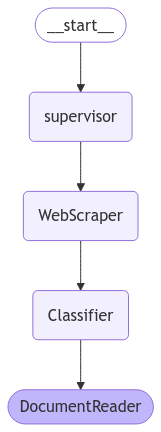

In [186]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))


In [183]:
# Input file containing URLs
input_file = "slack_urls/slack_channel_links_extracted.txt"

# Output file for results
output_file = "output/output_results.txt"

# Read URLs from input file, stripping whitespace and empty lines
with open(input_file, 'r', encoding='utf-8') as file:
    urls = [line.strip() for line in file if line.strip()]

# Open output file in write mode
with open(output_file, 'w', encoding='utf-8') as output:
    for url in urls:
        # Process each URL through research_chain.stream
        output_messages = []
        for s in research_chain.stream(
            url,  # Use the actual URL from the file
            {"recursion_limit": 100}):
            
            # Collect messages that aren't end markers
            if "__end__" not in s:
                output_messages.append(s)

        # Process results if we have any messages
        if output_messages:
            for output_message in output_messages:
                # First process Classifier messages
                if 'Classifier' in output_message:
                    classifiers = output_message['Classifier']
                    for valor in classifiers.values():
                        for idx, elemento in enumerate(valor, start=1):
                            if idx == 3 and hasattr(elemento, 'content'):
                                output.write(f"URL: {url}\n")
                                output.write(f"Classifier Content: {elemento.content}\n\n")
                                print(f"Processed URL: {url}")
                                print(f"Classifier Content: {elemento.content}")

                # Then process DocumentReader messages for the same URL
                if 'DocumentReader' in output_message:
                    documents_readers = output_message['DocumentReader']
                    for valor in documents_readers.values():
                        for idx, elemento in enumerate(valor, start=1):
                            if idx == len(valor) and hasattr(elemento, 'content'):
                                output.write(f"DocumentReader Content: {elemento.content}\n\n")
                                print(f"DocumentReader Content: {elemento.content}")


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://www.benzinga.com/news/24/12/42316845/ethereum-soars-50-in-a-month-as-trader-forecasts-a-legendary-breakout-south-korean-president-yoon-suk-yeol-faces-impeachment-calls-following-a-short-lived-martial-law-top-headlines-today-while
Classifier Content: Based on the provided summary of the Benzinga article, the article appears to cover a wide range of topics with a significant focus on current events, financial markets, and political developments, including a detailed update on Ethereum's performance. However, without in-depth technical analysis or groundbreaking insights into the cryptocurrency domain, especially Ethereum's technology or its potential impact on the digital currency ecosystem, the content seems to offer a broad overview rather than deep, technical, or innovative analysis.

Given the information:

- The article provides a **comprehensive overview** of current events, including a significant update on Ethereum's market performance, which makes it relev

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://blockchain.news/news/ethereum-foundation-internship-2025
Classifier Content: Based on the provided details, this article can be classified as a **Score 5** on the scale of cryptocurrency document quality. Here's the rationale:

1. **Why this score was chosen:**
   - The article provides **factually correct** information about the Ethereum Foundation's 2025 summer internship program. It outlines the application deadline, internship overview, eligibility, application process, program opportunities, and mentoring teams, which offers **additional context** and connects well with the main topic.
   - It introduces **basic development of ideas**, such as detailing the specific areas interns will work on (e.g., protocol security, account abstraction, and scaling research) and the nature of the work environment (remote or on-site). This enhances understanding but remains somewhat **superficial**.
   - The content is **well-organized** and flows logically, making it easy 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://bravenewcoin.com/insights/set-to-challenge-ethereums-dominance-could-this-next-gen-blockchain-redefine-decembers-crypto-market
Classifier Content: Based on the provided summary, the article would be classified with a **Score of 6** under the specified rating system. Here’s the rationale:

1. **Why this score was chosen**:
   - The article provides **accurate and well-sourced information** about Lightchain Protocol AI, comparing it with Ethereum and highlighting its unique features like the Proof of Intelligence (PoI) consensus mechanism and the Artificial Intelligence Virtual Machine (AIVM).
   - It offers a **practical overview** of how Lightchain could impact the crypto market, particularly focusing on its potential applications in DeFi, supply chains, dApps, and Memecoin Launchpad.
   - The content is **organized** and **contextually relevant**, providing insights into the challenges faced by Ethereum and how Lightchain aims to address them, thus making it use

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://www.chaincatcher.com/en/article/2155249
Classifier Content: The description provided suggests that the article from ChainCatcher, which reports on the issuance of an additional 50 million USDC on the Ethereum chain and includes a cautionary note about blockchain activities and token speculations, can be classified within a specific quality range according to the criteria provided.

### Classification: Score 6

**Reasoning for Score 6:**
- **Accurate and well-sourced:** The article reports on a specific event (the issuance of 50 million USDC) that can be verified and is likely sourced from reputable channels like Whale Alert, indicating factual accuracy and solid sourcing.
- **Technical detail explored but not fully developed:** The report provides specific information about blockchain activity (issuance of USDC on Ethereum) but does not delve deeply into the technical implications or broader market impact.
- **Well-organized:** The brief description suggests the 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://decrypt.co/294883/xai-tiny-sentry-keys-ethereum-gaming
Classifier Content: Based on the classification system provided, the article about Xai's introduction of "Tiny Sentry Keys" on the Ethereum layer-3 gaming network is classified as a **Score 6**. Here's the rationale for this classification:

1. **Why this score was chosen**:
   - The article provides **accurate and well-sourced information** about Xai’s initiative, including details about the distribution of rewards and the strategic introduction of Tiny Sentry Keys to lower the entry barrier for participants.
   - It explores **technical detail** at a basic to moderate level, explaining the purpose of Sentry Keys and how they integrate with the network’s gaming ecosystem.
   - The content is **well-organized**, making it easy to follow, and includes relevant visual elements like pricing comparisons between regular and tiny Sentry Keys.
   - While the article offers practical overviews of Xai’s efforts to exp

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://dailyhodl.com/2024/12/03/ethereum-memecoin-thats-up-8776-this-year-placed-on-coinbase-listing-roadmap/
Classifier Content: Based on the provided article information, the classification score is **4**. Here's the justification for this classification:

1. **Why Score 4 is Chosen**:
   - The article provides **factually correct information** about MOG Coin, including its significant price increase, its availability on multiple blockchains, and its listings on several crypto exchanges.
   - It introduces MOG Coin and Moo Deng with basic background information, such as the origin of MOG Coin and its cultural reference.
   - The content is **clear and organized**, making it straightforward for readers to follow the updates regarding Coinbase's listing roadmap.

2. **Justification Against Adjacent Scores**:
   - **Not a Score 3**: The article surpasses a score of 3 by providing **minimal context** about MOG Coin and Moo Deng, including their market performance and sign

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://www.blockhead.co/2024/12/04/dtcpay-abandons-bitcoin-ethereum-for-stablecoins-2/
Classifier Content: Based on the provided summary of the article, it appears to fall into the **Score 6** category on the classification scale. Here's why:

1. **Why Score 6 was chosen**:
   - The article presents **accurate and well-sourced information** about dtcpay's strategic shift from Bitcoin and Ethereum to stablecoins, indicating a well-researched piece.
   - It explores **technical details** at a basic to moderate level by discussing the move to stablecoins and the reasons behind this decision, such as minimizing volatility.
   - The content is **well-organized** and likely uses **appropriate visuals or data** from Chainalysis to support its points, making it easier for the reader to understand the significance of the shift.
   - It **lacks significant innovation or new ideas** but provides a practical overview and relevant real-world implications of stablecoin adoption in di

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://decrypt.co/294635/illuvium-ethereum-game-casio-g-shock-collab
Classifier Content: Given the information provided from the article about the collaboration between Illuvium and Casio's G-Shock, and how it integrates NFTs into a blockchain-based game, the article can be classified under the scoring system for cryptocurrency content quality.

**Score Classification: 6**

**Rationale for Score 6:**
1. **Accurate and Well-Sourced Information:** The article provides factual information regarding the collaboration between Illuvium and Casio's G-Shock, with mention of the game's features, such as the sale dates and prices for the NFTs.
2. **Technical Detail Explored:** While the article touches upon the concept of NFTs within the Illuvium Beyond game, it offers a basic to moderate level of technical detail about the collaboration and the game's mechanics.
3. **Well-Organized:** The article is structured in a manner that clearly outlines the collaboration, the specific det

In [184]:
for s in research_chain.stream(
"https://thepaypers.com/online-mobile-banking/bitwise-acquires-ethereum-staking-provider-attestant-limited--1271002 ",
    {"recursion_limit": 100}

):
    if "FINISH" not in s:
        print(s)
        print("---")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'WebScraper'}}
---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'WebScraper': {'messages': [HumanMessage(content="Bitwise Asset Management has acquired Attestant Limited, an institutional-grade Ethereum staking service provider. Attestant, which manages $3.7 billion in staked assets, will enhance Bitwise's investment offerings, including non-custodial staking, ETPs, hedge funds, private funds, and separately managed account strategies. The acquisition aims to expand Bitwise's capabilities in supporting cryptocurrency investors by offering more comprehensive investment solutions. Attestant's services will continue under Bitwise's new Onchain Solutions group, focusing on enhancing Ethereum staking and developing services for additional protocols without disrupting existing services.", additional_kwargs={}, response_metadata={}, name='WebScraper')]}}
---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'Classifier': {'messages': [HumanMessage(content='https://thepaypers.com/online-mobile-banking/bitwise-acquires-ethereum-staking-provider-attestant-limited--1271002 ', additional_kwargs={}, response_metadata={}, id='3aeede2f-76ea-4dff-9ba3-f8d47bc0a8e2'), HumanMessage(content="Bitwise Asset Management has acquired Attestant Limited, an institutional-grade Ethereum staking service provider. Attestant, which manages $3.7 billion in staked assets, will enhance Bitwise's investment offerings, including non-custodial staking, ETPs, hedge funds, private funds, and separately managed account strategies. The acquisition aims to expand Bitwise's capabilities in supporting cryptocurrency investors by offering more comprehensive investment solutions. Attestant's services will continue under Bitwise's new Onchain Solutions group, focusing on enhancing Ethereum staking and developing services for additional protocols without disrupting existing services.", additional_kwargs={}, response_metadata={

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'DocumentReader': {'messages': [HumanMessage(content='https://thepaypers.com/online-mobile-banking/bitwise-acquires-ethereum-staking-provider-attestant-limited--1271002 ', additional_kwargs={}, response_metadata={}, id='3aeede2f-76ea-4dff-9ba3-f8d47bc0a8e2'), HumanMessage(content="Bitwise Asset Management has acquired Attestant Limited, an institutional-grade Ethereum staking service provider. Attestant, which manages $3.7 billion in staked assets, will enhance Bitwise's investment offerings, including non-custodial staking, ETPs, hedge funds, private funds, and separately managed account strategies. The acquisition aims to expand Bitwise's capabilities in supporting cryptocurrency investors by offering more comprehensive investment solutions. Attestant's services will continue under Bitwise's new Onchain Solutions group, focusing on enhancing Ethereum staking and developing services for additional protocols without disrupting existing services.", additional_kwargs={}, response_metada

In [185]:
#input_file = "slack_urls/slack_channel_links_extracted.txt"
#with open(input_file, 'r', encoding='utf-8') as file:
#            urls = [line.strip() for line in file if line.strip()]
#            for url in urls:
#                for s in research_chain.stream(
#                "Enter to this url" + url + " and put a scoring and justification based on the criteria of the Classifier agent", {"recursion_limit": 100}):
#                    if "__end__" not in s:
#                        output_messages = []
#                        output_messages.append(s)
#                if output_messages:
#                    print("Final Result:")
#                    for output_message in output_messages:
#                        classifiers=output_message['Classifier']
#                        for valor in classifiers.values():
#                            for idx, elemento in enumerate(valor, start=1):
#                                #print(elemento)
#                                if idx == 3 :  # Verifica si es el tercer elemento y del tipo AIMessage
#                                   print(elemento.content)